In [23]:
"""
Clean Codebase for DP-Based Partitioning & Offline Scheduling

This notebook defines:
  - Node class to manage task execution on a given device.
  - Utility functions: resolve_arg, move_tensor_to_device, measure_max_transfer_penalty.
  - Profiler class (unchanged).
  - HPCUtilizationMetric class (which returns raw per-layer execution times).
  - Task class with a method run_offline_partition_makespan() that partitions the FX graph layers
    using a DP algorithm that minimizes the overall makespan.
  - Stage class representing a block of layers (a stage) scheduled on one node.
  - Taskset class that creates a DP-based partitioning for each Task and then executes them.
  - Evaluator class to compare naive (sequential) and parallel executions.
  - Test models and dataloader utilities.
  - run_experiment() and run_multiple_experiments() functions for experiments.
"""

import os
import io
import copy
import time
import queue
import threading
import torch
import torch.fx as fx
import torch.nn as nn
import torch.profiler
import torch.cuda
import networkx as nx
import pandas as pd
from torch.fx import Node as FxNode
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models
from typing import Callable, Any, List, Dict, Optional, Set, Tuple
import matplotlib.pyplot as plt
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed

## Node

**Description:**  
The **Node** class represents a compute node (a CPU core or a GPU with an associated CPU core) responsible for executing tasks. Each node maintains its own task queue and runs a dedicated worker thread. Before executing a task, it sets the proper CPU affinity and GPU device context. Additionally, the class provides a static method to discover available nodes based on the system’s resources.

---

In [24]:
##############################################################################
# Node Class
##############################################################################

class Node:
    def __init__(self, node_id: str, cpus=None, gpu=None):
        self._node_id = node_id
        self._cpus = tuple(cpus or [])
        self._gpu = gpu
        self._original_affinity = os.sched_getaffinity(0)
        self._task_queue = queue.Queue()
        self._stop_signal = False
        self._worker_thread = threading.Thread(target=self._worker_loop, daemon=True)
        self._worker_thread.start()
        self.current_load = 0.0
        self.assigned_stages = []
    @property
    def node_id(self):
        return self._node_id
    @property
    def cpus(self):
        return self._cpus
    @property
    def gpu(self):
        return self._gpu
    def assign_task(self, func: Callable, *args, **kwargs) -> queue.Queue:
        result_queue = queue.Queue(maxsize=1)
        self._task_queue.put((func, args, kwargs, result_queue))
        return result_queue
    def stop(self):
        self._stop_signal = True
        self._task_queue.put(None)
        self._worker_thread.join()
    def _worker_loop(self):
        while not self._stop_signal:
            item = self._task_queue.get()
            if item is None:
                break
            func, args, kwargs, result_queue = item
            try:
                self._set_context()
                result = func(*args, **kwargs)
            except Exception as e:
                result = e
            finally:
                self._reset_context()
            result_queue.put(result)
    def _set_context(self):
        if self._cpus:
            os.sched_setaffinity(0, self._cpus)
        if self._gpu is not None and torch.cuda.is_available():
            torch.cuda.set_device(self._gpu)
            torch.cuda.synchronize(self._gpu)
    def _reset_context(self):
        os.sched_setaffinity(0, self._original_affinity)
        if self._gpu is not None and torch.cuda.is_available():
            torch.cuda.synchronize(self._gpu)
    @staticmethod
    def discover_nodes(disjoint: bool = True) -> List['Node']:
        nodes = []
        num_cpus = os.cpu_count() or 1
        ngpus = torch.cuda.device_count()
        if not disjoint:
            for core_id in range(num_cpus):
                nodes.append(Node(node_id=f"CPU-{core_id}", cpus=[core_id]))
            for g in range(ngpus):
                for core_id in range(num_cpus):
                    nodes.append(Node(node_id=f"GPU-{g}-CPU-{core_id}", cpus=[core_id], gpu=g))
        else:
            cpu_nodes = [Node(node_id=f"CPU-{i}", cpus=[i]) for i in range(num_cpus)]
            gpu_nodes = []
            for g in range(ngpus):
                if cpu_nodes:
                    cpu_node = cpu_nodes.pop()
                    gpu_nodes.append(Node(node_id=f"GPU-{g}-CPU-{cpu_node.cpus[0]}", cpus=[cpu_node.cpus[0]], gpu=g))
                else:
                    gpu_nodes.append(Node(node_id=f"GPU-{g}", cpus=[], gpu=g))
            nodes = gpu_nodes + cpu_nodes
        return nodes
    def __repr__(self):
        return f"Node({self._node_id}, cpus={self._cpus}, gpu={self._gpu})"

## Utility Functions

**Description:**  
Several helper functions support the overall framework:
- **resolve_arg:** Recursively resolves arguments containing FX nodes using a dictionary of node outputs.
- **move_tensor_to_device:** Transfers tensors (or nested containers of tensors) to a specified device.
- **measure_max_transfer_penalty:** Measures the maximum time needed to transfer a tensor between different nodes.
- **Other helpers:** Functions like `set_seed` and `create_dataloader` ensure reproducibility and facilitate synthetic data generation.

---

## Metric Interface and Default Metric Class

## HPCUtilizationMetric

**Description:**  
The **HPCUtilizationMetric** class provides methods to compute performance metrics. It calculates:
- The overall forward pass execution time for a task.
- The execution time of individual layers (FX nodes) based on profiling records.

These metrics are used to guide the dynamic programming (DP) partitioning process to minimize the overall makespan.

In [25]:


##############################################################################
# Utility Functions
##############################################################################
def resolve_arg(arg: Any, node_outputs: Dict[str, torch.Tensor]) -> Any:
    if isinstance(arg, FxNode):
        return node_outputs.get(arg.name, arg)
    elif isinstance(arg, (list, tuple)):
        return type(arg)(resolve_arg(a, node_outputs) for a in arg)
    elif isinstance(arg, dict):
        return {k: resolve_arg(v, node_outputs) for k, v in arg.items()}
    else:
        return arg

def move_tensor_to_device(obj, device):
    if isinstance(obj, torch.Tensor):
        return obj.to(device, non_blocking=True) if obj.device != device else obj
    elif isinstance(obj, (list, tuple)):
        return type(obj)(move_tensor_to_device(x, device) for x in obj)
    elif isinstance(obj, dict):
        return {k: move_tensor_to_device(v, device) for k, v in obj.items()}
    else:
        return obj

def measure_max_transfer_penalty(available_nodes: List[Node], sample_tensor: torch.Tensor) -> float:
    max_time = 0.0
    for src in available_nodes:
        src_device = torch.device(f"cuda:{src.gpu}") if src.gpu is not None and torch.cuda.is_available() else torch.device("cpu")
        tensor_on_src = sample_tensor.to(src_device)
        for dst in available_nodes:
            dst_device = torch.device(f"cuda:{dst.gpu}") if dst.gpu is not None and torch.cuda.is_available() else torch.device("cpu")
            start = time.time()
            _ = tensor_on_src.to(dst_device)
            if dst_device.type == 'cuda':
                torch.cuda.synchronize(dst_device)
            elapsed = time.time() - start
            max_time = max(max_time, elapsed)
    return max_time

class HPCUtilizationMetric:
    def __init__(self):
        pass
    def compute_task(self, task: "Task", taskset: "Taskset") -> float:
        return float(task.get_forward_pass_time(sum_across_compute=True))
    def compute_layer(self, task: "Task", node: Node, fx_node: FxNode) -> float:
        key = (node.node_id, fx_node.name)
        record = task.prof_records.get(key, None)
        if record is None:
            return 0.0
        return float(record.get("Total Execution Time (us)", 0.0))

## Profiler

**Description:**  
The **Profiler** class leverages PyTorch’s profiling tools to instrument and analyze a model’s performance. It:
- Traces the model’s FX graph and wraps key operations with profiling contexts.
- Collects metrics such as CPU/GPU execution times and memory usage.
- Caches and saves the profiling data (e.g., in CSV format).

This detailed performance data is critical for the subsequent partitioning and scheduling decisions in tasks.

---

In [26]:
##############################################################################
# Profiler Class
##############################################################################

class Profiler:
    def __init__(self, mode: str, profile_db_path='profiling_results.csv', log_dir='logs'):
        assert mode in ['init', 'runtime'], "Mode must be 'init' or 'runtime'"
        self.mode = mode
        self.profile_db_path = profile_db_path
        self.log_dir = log_dir
        os.makedirs(self.log_dir, exist_ok=True)
        self.columns = ['Task_ID', 'Model', 'Layer', 'Compute',
                        'Self CPU (us)', 'CPU Total (us)', 'CUDA Total (us)',
                        'Self CPU Mem (bytes)', 'Self CUDA Mem (bytes)',
                        'Total Execution Time (us)', 'Total Memory Used (bytes)']
        if os.path.exists(self.profile_db_path):
            self.profile_db = pd.read_csv(self.profile_db_path)
        else:
            self.profile_db = pd.DataFrame(columns=self.columns)
        self.runtime_csv = os.path.join(self.log_dir, 'runtime_results.csv')
        if not os.path.exists(self.runtime_csv):
            pd.DataFrame(columns=['Task_ID', 'Model', 'Layer', 'Compute', 'Execution Time (us)']).to_csv(self.runtime_csv, index=False)
        self.observation_window = 0.0
        self.profile_cache: Dict[Tuple[str, str], pd.DataFrame] = {}

    def profile_model(self,
                      model: nn.Module,
                      input_data: Any,
                      node: "Node",
                      task_id: str,
                      warmup_iters: int = 3,
                      profile_iters: int = 5):
        cache_key = (model.__class__.__name__, node.node_id)
        if cache_key in self.profile_cache:
            cached_data = self.profile_cache[cache_key].copy()
            cached_data['Task_ID'] = task_id
            self.profile_db = pd.concat([self.profile_db, cached_data], ignore_index=True)
            print(f"[Profiler] Reused cached profiling data for {model.__class__.__name__} on {node.node_id}.")
            return

        old_affinity = os.sched_getaffinity(0)
        try:
            if node.cpus:
                os.sched_setaffinity(0, node.cpus)
            if node.gpu is not None and torch.cuda.is_available():
                torch.cuda.set_device(node.gpu)
                device = torch.device(f"cuda:{node.gpu}")
            else:
                device = torch.device("cpu")
            model_copy = self._clone_model_safely(model)
            instrumented_model = self._trace_and_instrument_model(model_copy)
            instrumented_model.to(device)
            instrumented_model.eval()
            with torch.no_grad():
                for _ in range(warmup_iters):
                    _ = instrumented_model(input_data.to(device))
            print(f"[Profiler] Starting profiling for Task '{task_id}' on {node.node_id} (device={device}).")
            with torch.profiler.profile(
                activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
                schedule=torch.profiler.schedule(wait=1, warmup=1, active=profile_iters),
                on_trace_ready=lambda prof: self._trace_handler(prof, task_id, model.__class__.__name__, node.node_id),
                record_shapes=True,
                profile_memory=True,
                with_stack=True
            ) as prof:
                for _ in range(profile_iters):
                    with torch.no_grad():
                        _ = instrumented_model(input_data.to(device))
                    if device.type == 'cuda':
                        torch.cuda.synchronize(device)
                    prof.step()
            time.sleep(0.0001)
            new_rows = self.profile_db[self.profile_db['Task_ID'] == task_id].copy()
            self.profile_cache[cache_key] = new_rows
            self.profile_db.to_csv(self.profile_db_path, index=False)
            print(f"[Profiler] Profiling complete. Data saved to {self.profile_db_path}.")
        finally:
            os.sched_setaffinity(0, old_affinity)

    def _clone_model_safely(self, model: nn.Module) -> nn.Module:
        try:
            return copy.deepcopy(model)
        except Exception as e:
            print(f"[Profiler] deepcopy failed: {e}. Falling back to torch.save/load.")
            buffer = io.BytesIO()
            torch.save(model, buffer)
            buffer.seek(0)
            return torch.load(buffer)

    def _trace_and_instrument_model(self, model: nn.Module) -> fx.GraphModule:
        tracer = fx.Tracer()
        graph = tracer.trace(model)
        graph_module = fx.GraphModule(model, graph)
        profiler_attr_prefix = "_profiler_wrapped_"
        for node in list(graph.nodes):
            node_name = node.name
            if node.op == 'call_function':
                func = node.target
                wrapped_func_name = f"{profiler_attr_prefix}{node_name}_{id(func)}"
                def make_wrapped_func(original_func, profile_name):
                    def wrapped(*args, **kwargs):
                        with torch.profiler.record_function(profile_name):
                            return original_func(*args, **kwargs)
                    return wrapped
                wrapped_func = make_wrapped_func(func, node_name)
                setattr(model, wrapped_func_name, wrapped_func)
                node.target = getattr(model, wrapped_func_name)
            elif node.op == 'call_module':
                submodule = dict(model.named_modules())[node.target]
                func = submodule.forward
                wrapped_func_name = f"{profiler_attr_prefix}{node_name}_{id(func)}"
                def make_wrapped_forward(original_forward, profile_name):
                    def wrapped_forward(*args, **kwargs):
                        with torch.profiler.record_function(profile_name):
                            return original_forward(*args, **kwargs)
                    return wrapped_forward
                wrapped_forward = make_wrapped_forward(func, node_name)
                setattr(submodule, wrapped_func_name, wrapped_forward)
                submodule.forward = getattr(submodule, wrapped_func_name)
            elif node.op == 'call_method':
                method_name = node.target
                obj = node.args[0]
                original_method = getattr(obj, method_name, None)
                if original_method is None:
                    continue
                wrapped_method_name = f"{profiler_attr_prefix}{node_name}_{id(original_method)}"
                def make_wrapped_method(orig_meth, profile_name):
                    def wrapped_method(*args, **kwargs):
                        with torch.profiler.record_function(profile_name):
                            return orig_meth(*args, **kwargs)
                    return wrapped_method
                wrapped_method = make_wrapped_method(original_method, node_name)
                setattr(obj, wrapped_method_name, wrapped_method)
            # Placeholders need no instrumentation.
        graph_module.recompile()
        return graph_module

    def _trace_handler(self, prof, task_id: str, model_name: str, node_id: str):
        self._process_profiler_data(prof, task_id, model_name, node_id)

    def _process_profiler_data(self, profiler, task_id: str, model_name: str, node_id: str):
        aggregated = {}
        forward_pass = {
            'Task_ID': task_id,
            'Model': model_name,
            'Layer': 'forward_pass',
            'Compute': node_id,
            'Self CPU (us)': 0.0,
            'CPU Total (us)': 0.0,
            'CUDA Total (us)': 0.0,
            'Self CPU Mem (bytes)': 0,
            'Self CUDA Mem (bytes)': 0,
            'Total Execution Time (us)': 0.0,
            'Total Memory Used (bytes)': 0
        }
        events = profiler.key_averages()
        for evt in events:
            layer_name = evt.key
            if layer_name.startswith("aten::"):
                continue
            forward_pass['Self CPU (us)'] += evt.self_cpu_time_total
            forward_pass['CPU Total (us)'] += evt.cpu_time_total
            forward_pass['CUDA Total (us)'] += getattr(evt, 'cuda_time_total', 0.0)
            forward_pass['Self CPU Mem (bytes)'] += getattr(evt, 'self_cpu_memory_usage', 0)
            forward_pass['Self CUDA Mem (bytes)'] += getattr(evt, 'self_cuda_memory_usage', 0)
            forward_pass['Total Execution Time (us)'] += evt.cpu_time_total + getattr(evt, 'cuda_time_total', 0.0)
            forward_pass['Total Memory Used (bytes)'] += getattr(evt, 'self_cpu_memory_usage', 0) + getattr(evt, 'self_cuda_memory_usage', 0)
            if layer_name not in aggregated:
                aggregated[layer_name] = {
                    'Task_ID': task_id,
                    'Model': model_name,
                    'Layer': layer_name,
                    'Compute': node_id,
                    'Self CPU (us)': 0.0,
                    'CPU Total (us)': 0.0,
                    'CUDA Total (us)': 0.0,
                    'Self CPU Mem (bytes)': 0,
                    'Self CUDA Mem (bytes)': 0,
                    'Total Execution Time (us)': 0.0,
                    'Total Memory Used (bytes)': 0
                }
            aggregated[layer_name]['Self CPU (us)'] += evt.self_cpu_time_total
            aggregated[layer_name]['CPU Total (us)'] += evt.cpu_time_total
            aggregated[layer_name]['CUDA Total (us)'] += getattr(evt, 'cuda_time_total', 0.0)
            aggregated[layer_name]['Self CPU Mem (bytes)'] += getattr(evt, 'self_cpu_memory_usage', 0)
            aggregated[layer_name]['Self CUDA Mem (bytes)'] += getattr(evt, 'self_cuda_memory_usage', 0)
            aggregated[layer_name]['Total Execution Time (us)'] += evt.cpu_time_total + getattr(evt, 'cuda_time_total', 0.0)
            aggregated[layer_name]['Total Memory Used (bytes)'] += getattr(evt, 'self_cpu_memory_usage', 0) + getattr(evt, 'self_cuda_memory_usage', 0)
        self.profile_db = self._upsert(self.profile_db, forward_pass)
        for data in aggregated.values():
            self.profile_db = self._upsert(self.profile_db, data)
        self.profile_db.to_csv(self.profile_db_path, index=False)

    def _upsert(self, df: pd.DataFrame, row: Dict[str, Any]) -> pd.DataFrame:
        mask = (df['Task_ID'] == row['Task_ID']) & (df['Model'] == row['Model']) & (df['Layer'] == row['Layer']) & (df['Compute'] == row['Compute'])
        if mask.any():
            existing_time = df.loc[mask, 'Total Execution Time (us)'].max()
            if row['Total Execution Time (us)'] > existing_time:
                for key in self.columns:
                    df.loc[mask, key] = row[key]
        else:
            df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
        return df

    def get_profile_db(self) -> pd.DataFrame:
        return self.profile_db

    def print_profile_db(self):
        if self.profile_db.empty:
            print("ProfileDB is empty.")
        else:
            print("ProfileDB:")
            print(self.profile_db.to_string(index=False))

## Task

**Description:**  
The **Task** class encapsulates a single model inference execution. It holds:
- The model and its input data.
- Profiling records and execution metrics.
- The results of a DP-based partitioning of the model’s FX graph into stages.

Each task manages the execution of its stages, tracks metrics (e.g., busy time, transfer time), and ultimately records the final output.

---

In [27]:
##############################################################################
# Task Class with DP-Based Partitioning (Minimizing Makespan)
##############################################################################
class Task:
    def __init__(self, task_id: str, model: nn.Module, input_data: torch.Tensor, model_name: str,
                 profiler: Profiler, load_metric: Optional[HPCUtilizationMetric] = None):
        self.task_id = task_id
        self.model = model
        self.input_data = input_data
        self.model_name = model_name
        self.profiler = profiler
        self.load_metric = load_metric if load_metric else HPCUtilizationMetric()
        self.stages: Dict[str, Stage] = {}
        self.graph = nx.DiGraph()
        self.start_time: Optional[float] = None
        self.finish_time: Optional[float] = None
        self.output_data: Optional[torch.Tensor] = None
        self.busy_time: float = 0.0
        self.computation_time: float = 0.0
        self.transfer_time: float = 0.0
        self.prof_records: Dict[Tuple[str, str], Dict[str, Any]] = {}
        self._available_nodes: List[Node] = []
        self.init_traced_graph: List[str] = []
        self.placeholder_names: Set[str] = set()
        self._initialize_dag()

    def _initialize_dag(self):
        tracer = fx.symbolic_trace(self.model)
        fx_nodes = list(tracer.graph.nodes)
        self.init_traced_graph = [node.name for node in fx_nodes]
        self.placeholder_names = set(n.name for n in fx_nodes if n.op == "placeholder")

    def get_forward_pass_time(self, sum_across_compute: bool = False) -> float:
        if not self.profiler:
            return 0.0
        df = self.profiler.get_profile_db()
        mask = (df['Task_ID'] == self.task_id) & (df['Model'] == self.model_name) & (df['Layer'] == 'forward_pass')
        matched = df.loc[mask]
        if matched.empty:
            return 0.0
        times = matched['Total Execution Time (us)']
        return float(times.sum()) if sum_across_compute else float(times.max())

    def populate_profile_records(self):
        if not self.profiler:
            return
        df = self.profiler.get_profile_db()
        mask_all = (df['Task_ID'] == self.task_id) & (df['Model'] == self.model_name)
        relevant = df.loc[mask_all]
        all_computes = relevant['Compute'].unique()
        for comp in all_computes:
            mask_comp = (relevant['Compute'] == comp)
            subdf = relevant.loc[mask_comp]
            for layer in self.init_traced_graph:
                row = subdf.loc[subdf['Layer'] == layer]
                if not row.empty:
                    self.prof_records[(comp, layer)] = row.iloc[0].to_dict()
                else:
                    self.prof_records[(comp, layer)] = None

    def run_offline_partition_makespan(self):
        """
        Uses DP to partition the model's layers into K blocks (K = number of available nodes)
        to minimize the overall makespan.
        """
        tracer = fx.symbolic_trace(self.model)
        fx_nodes = list(tracer.graph.nodes)
        L = len(fx_nodes)
        K = len(self._available_nodes)
        if L == 0 or K == 0:
            return
        # Precompute cost for block [i, j] on best node.
        cost = [[0.0 for _ in range(L)] for _ in range(L)]
        for i in range(L):
            for j in range(i, L):
                block_costs = []
                for node in self._available_nodes:
                    s = 0.0
                    for l in range(i, j + 1):
                        s += self.load_metric.compute_layer(self, node, fx_nodes[l])
                    block_costs.append(s)
                cost[i][j] = min(block_costs)
        # DP table: dp[i][k] = minimal possible maximum cost when partitioning layers 0..i into k blocks.
        dp = [[float("inf")] * (K + 1) for _ in range(L)]
        split = [[-1] * (K + 1) for _ in range(L)]
        for i in range(L):
            dp[i][1] = cost[0][i]
        for k in range(2, K + 1):
            for i in range(L):
                for x in range(0, i):
                    candidate = max(dp[x][k - 1], cost[x + 1][i])
                    if candidate < dp[i][k]:
                        dp[i][k] = candidate
                        split[i][k] = x
        optimal_makespan = dp[L - 1][K]
        # Backtrack to obtain partition indices.
        partitions = []
        k_val = K
        i_val = L - 1
        while k_val > 1:
            x = split[i_val][k_val]
            partitions.append((x + 1, i_val))
            i_val = x
            k_val -= 1
        partitions.append((0, i_val))
        partitions.reverse()
        # Create Stage objects from partitions.
        self.stages.clear()
        self.graph.clear()
        for idx, (start, end) in enumerate(partitions):
            stage_id = f"{self.task_id}-stage-{idx + 1}"
            best_node = None
            best_cost = float("inf")
            for node in self._available_nodes:
                s = 0.0
                for l in range(start, end + 1):
                    s += self.load_metric.compute_layer(self, node, fx_nodes[l])
                if s < best_cost:
                    best_cost = s
                    best_node = node
            stg = Stage(stage_id, fx_nodes[start:end + 1], best_node, self)
            stg.execution_time = best_cost
            self.stages[stage_id] = stg
            self.graph.add_node(stage_id, stage=stg)
        # Link stages sequentially.
        stage_ids = sorted(self.stages.keys(), key=lambda sid: int(sid.split("-")[-1]))
        for i in range(len(stage_ids) - 1):
            self.stages[stage_ids[i + 1]].add_dependency(stage_ids[i])
            self.stages[stage_ids[i]].add_dependent(stage_ids[i + 1])
            self.graph.add_edge(stage_ids[i], stage_ids[i + 1])
        self.finish_time = optimal_makespan

    def get_execution_order(self) -> List[str]:
        try:
            return list(nx.topological_sort(self.graph))
        except nx.NetworkXUnfeasible:
            raise ValueError("Cycle in stage DAG")

    def update_busy_time(self, exec_time: float, transfer_time: float = 0.0):
        self.busy_time += exec_time
        self.transfer_time += transfer_time
        self.computation_time += (exec_time - transfer_time)

    def set_output_data(self, output: torch.Tensor):
        self.output_data = output.cpu() if output is not None else None
        self.finish_time = time.time()

    def get_total_execution_time(self) -> float:
        if self.start_time and self.finish_time:
            return self.finish_time - self.start_time
        return 0.0

    def print_stage_allocations(self):
        print(f"=== Stage Allocations for Task {self.task_id} ===")
        for sid, stg in self.stages.items():
            layer_names = [fxn.name for fxn in stg.nodes]
            node_id = stg.assigned_node.node_id if stg.assigned_node else "Unassigned"
            print(f"{sid}: Node={node_id}, Layers={layer_names}, Deps={stg.dependencies}")

    def __repr__(self):
        return f"Task({self.task_id}, model={self.model_name})"


## Stage

**Description:**  
A **Stage** represents a contiguous block of FX nodes (or model layers) that will execute on a designated node. It is responsible for:
- Transferring data to the proper device.
- Sequentially executing its operations.
- Recording its execution and data transfer times.
- Managing dependencies with other stages to ensure correct execution order.

---

In [28]:
##############################################################################
# Stage Class
##############################################################################
class Stage:
    def __init__(self, stage_id: str, nodes: List[FxNode], assigned_node: Node, task: Task):
        self.stage_id = stage_id
        self.nodes = nodes
        self.assigned_node = assigned_node
        self.dependencies: List[str] = []
        self.dependents: List[str] = []
        self.execution_time: Optional[float] = None
        self.transfer_time: float = 0.0
        self.output_data: Optional[torch.Tensor] = None
        self.task = task
        self.stage_device: str = "cpu"
    def add_dependency(self, stage_id: str):
        self.dependencies.append(stage_id)
    def add_dependent(self, stage_id: str):
        self.dependents.append(stage_id)
    def run_stage(self, node_outputs: Dict[str, torch.Tensor]):
        start_time = time.time()
        transfer_time = 0.0
        if self.assigned_node and self.assigned_node.gpu is not None and torch.cuda.is_available():
            device = torch.device(f"cuda:{self.assigned_node.gpu}")
            self.stage_device = str(device)
        else:
            device = torch.device("cpu")
            self.stage_device = "cpu"
        try:
            with torch.no_grad():
                for fx_node in self.nodes:
                    resolved_args = resolve_arg(fx_node.args, node_outputs)
                    resolved_kwargs = resolve_arg(fx_node.kwargs, node_outputs)
                    t_start = time.time()
                    resolved_args = move_tensor_to_device(resolved_args, device)
                    resolved_kwargs = move_tensor_to_device(resolved_kwargs, device)
                    t_end = time.time()
                    transfer_time += (t_end - t_start)
                    if fx_node.op == "placeholder":
                        out = self.task.input_data.to(device)
                    elif fx_node.op == "get_attr":
                        out = getattr(self.task.model, fx_node.target)
                    elif fx_node.op == "call_module":
                        submodule = self.task.model.get_submodule(fx_node.target)
                        submodule.to(device)
                        out = submodule(*resolved_args, **resolved_kwargs)
                    elif fx_node.op == "call_function":
                        out = fx_node.target(*resolved_args, **resolved_kwargs)
                    elif fx_node.op == "call_method":
                        method = getattr(resolved_args[0], fx_node.target)
                        out = method(*resolved_args[1:], **resolved_kwargs)
                    elif fx_node.op == "output":
                        out = resolved_args[0]
                    else:
                        raise NotImplementedError(f"Operation '{fx_node.op}' is not supported.")
                    node_outputs[fx_node.name] = out
        except Exception as e:
            print(f"[Stage] {self.stage_id} error: {e}")
            self.execution_time = float('inf')
            self.transfer_time = float('inf')
            node_outputs[self.stage_id] = None
            return
        finally:
            if device.type == 'cuda':
                torch.cuda.synchronize(device)
            end_time = time.time()
            self.execution_time = end_time - start_time
            self.transfer_time = transfer_time
        self.task.update_busy_time(self.execution_time, self.transfer_time)
        if not self.dependents:
            final_output_node = next((n for n in self.nodes if n.op == 'output'), None)
            if final_output_node:
                arg = final_output_node.args[0]
                if isinstance(arg, torch.Tensor):
                    final_res = arg.cpu()
                elif isinstance(arg, FxNode):
                    final_res = node_outputs.get(arg.name, None)
                else:
                    final_res = None
                self.task.set_output_data(final_res)
            else:
                self.task.set_output_data(None)
        print(f"[Stage] {self.stage_id}: Executed on {self.assigned_node.node_id} in {self.execution_time:.4f} s, Transfer: {self.transfer_time:.4f} s.")
    def __repr__(self):
        return (f"Stage({self.stage_id}, device={self.stage_device}, node={self.assigned_node.node_id if self.assigned_node else 'None'}, "
                f"deps={self.dependencies}, exec_time={self.execution_time}, transfer_time={self.transfer_time})")

## Taskset

**Description:**  
The **Taskset** class manages a collection of tasks. Its main responsibilities include:
- Running DP-based partitioning for each task.
- Scheduling the execution of task stages across available nodes in parallel.
- Calculating overall performance metrics such as makespan, throughput, and node utilization.

It abstracts the complexity of coordinating multiple tasks on heterogeneous computing resources.

---

In [29]:
##############################################################################
# Taskset Class (Using DP-Based Partitioning for Makespan)
##############################################################################
class Taskset:
    def __init__(self, tasks: List[Task], available_nodes: List[Node],
                 metric: Optional[HPCUtilizationMetric] = None):
        self.tasks = tasks
        self.available_nodes = sorted(available_nodes, key=lambda n: 0 if n.gpu is not None else 1)
        self.metric = metric if metric else HPCUtilizationMetric()
        if self.tasks and self.available_nodes:
            sample_tensor = self.tasks[0].input_data
            penalty = measure_max_transfer_penalty(self.available_nodes, sample_tensor)
            print(f"Measured max transfer penalty: {penalty:.6f} s")
            self.metric.transfer_penalty = penalty
        self.total_utilization = 0.0
        self.average_turnaround_time = 0.0
        self.throughput = 0.0
        self.makespan = 0.0
        self.task_completion_rate = 0.0
        self.loads: Dict[str, float] = {}
        for t in self.tasks:
            t.load_metric = self.metric
            self.loads[t.task_id] = t.load_metric.compute_task(t, self)
            t._available_nodes = self.available_nodes
            t.run_offline_partition_makespan()
    def execute_all(self):
        threads = []
        for t in self.tasks:
            thr = threading.Thread(target=self._execute_task, args=(t,))
            thr.start()
            threads.append(thr)
        for thr in threads:
            thr.join()
        self._calculate_metrics()
    def _execute_task(self, task: Task):
        print(f"[Taskset] Starting Task {task.task_id}")
        task.start_time = time.time()
        try:
            order = task.get_execution_order()
        except ValueError as e:
            print(f"[Taskset] {task.task_id} error: {e}")
            return
        node_outputs = {}
        for sid in order:
            stg = task.stages[sid]
            def run_stage(s=stg):
                s.run_stage(node_outputs)
            rq = stg.assigned_node.assign_task(run_stage)
            rq.get()
        task.finish_time = time.time()
        print(f"[Taskset] Completed Task {task.task_id} in {task.finish_time - task.start_time:.2f} s")
    def _calculate_metrics(self):
        total_busy_time = sum(stg.execution_time for t in self.tasks for stg in t.stages.values() if stg.execution_time)
        earliest_start = min((t.start_time for t in self.tasks if t.start_time), default=None)
        latest_finish = max((t.finish_time for t in self.tasks if t.finish_time), default=None)
        obs = (latest_finish - earliest_start) if earliest_start and latest_finish else 0.0
        used_nodes = {stg.assigned_node.node_id for t in self.tasks for stg in t.stages.values() if stg.assigned_node}
        total_available_time = obs * len(used_nodes)
        self.total_utilization = total_busy_time / total_available_time if total_available_time > 0 else 0.0
        ttimes = [t.get_total_execution_time() for t in self.tasks if t.start_time and t.finish_time]
        self.average_turnaround_time = sum(ttimes) / len(ttimes) if ttimes else 0.0
        self.makespan = obs
        self.throughput = len(self.tasks) / obs if obs > 0 else 0.0
        done = [t for t in self.tasks if t.output_data is not None]
        self.task_completion_rate = len(done) / len(self.tasks) if self.tasks else 0.0
    def __repr__(self):
        return (f"Taskset(num_tasks={len(self.tasks)}, makespan={self.makespan:.4f}s, "
                f"utilization={self.total_utilization:.2%}, throughput={self.throughput:.3f} tasks/s, "
                f"avg_turnaround={self.average_turnaround_time:.4f}s, completion_rate={self.task_completion_rate:.2%})")


## Evaluator

**Description:**  
The **Evaluator** class compares two execution strategies:
- **Naive Execution:** Running tasks sequentially (or asynchronously without partitioning).
- **Parallel Execution:** Utilizing DP-based partitioning and scheduling.

It gathers outputs, measures execution times, validates output correctness, and computes performance metrics (speedup, throughput, etc.) to analyze the benefits of the parallel scheduling approach.

---

In [30]:


##############################################################################
# Evaluator Class
##############################################################################
class Evaluator:
    def __init__(self, taskset: Taskset, profiler: Profiler):
        self.taskset = taskset
        self.profiler = profiler
        self.naive_outputs: Dict[str, torch.Tensor] = {}
        self.parallel_outputs: Dict[str, torch.Tensor] = {}
        self.naive_execution_times: Dict[str, float] = {}
        self.parallel_execution_times: Dict[str, float] = {}
        self.naive_completion_times: Dict[str, float] = {}
        self.parallel_completion_times: Dict[str, float] = {}
        self.naive_makespan: float = 0.0
        self.parallel_makespan: float = 0.0
        self.speedup_makespan: float = 0.0
        self.throughput_makespan: float = 0.0

    def run_naive_execution(self):
        print("[Evaluator] Starting Naive Execution.")
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if device.type == 'cuda':
          print("Running on cuda")
        else:
          print("Running on cpu")
        start = time.time()
        for task in self.taskset.tasks:
            task.model.to(device)
            inp = task.input_data.to(device)
            t0 = time.time()
            with torch.no_grad():
                out = task.model(inp)
            if device.type == 'cuda':
                torch.cuda.synchronize()
            t1 = time.time()
            et = t1 - t0
            self.naive_execution_times[task.task_id] = et
            self.naive_completion_times[task.task_id] = time.time() - start
            self.naive_outputs[task.task_id] = out.cpu()
            print(f"[Evaluator] Task {task.task_id}: Naive exec time: {et:.4f}s")
        self.naive_makespan = time.time() - start
        print(f"[Evaluator] Naive makespan: {self.naive_makespan:.4f}s\n")


    # def run_naive_execution(self):
    #     print("[Evaluator] Starting Async Execution.")
    #     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #     if device.type == 'cuda':
    #         print("Running on cuda")
    #     else:
    #         print("Running on cpu")
    #     start = time.time()

    #     def execute_task(task):
    #         # Move the model and input to the selected device
    #         task.model.to(device)
    #         inp = task.input_data.to(device)
    #         t0 = time.time()
    #         with torch.no_grad():
    #             out = task.model(inp)
    #         # If using CUDA, synchronize to get an accurate execution time
    #         if device.type == 'cuda':
    #             torch.cuda.synchronize()
    #         t1 = time.time()
    #         et = t1 - t0
    #         # Record the time elapsed since the start of the entire execution
    #         completion_time = time.time() - start
    #         # Return all necessary results along with the task id
    #         return task.task_id, et, completion_time, out.cpu()

    #     # Use ThreadPoolExecutor to run tasks concurrently
    #     with ThreadPoolExecutor(max_workers=len(self.taskset.tasks)) as executor:
    #         # Launch all tasks asynchronously
    #         futures = [executor.submit(execute_task, task) for task in self.taskset.tasks]
    #         for future in as_completed(futures):
    #             task_id, et, completion_time, output = future.result()
    #             self.naive_execution_times[task_id] = et
    #             self.naive_completion_times[task_id] = completion_time
    #             self.naive_outputs[task_id] = output
    #             print(f"[Evaluator] Task {task_id}: Async exec time: {et:.4f}s")

    #     self.naive_makespan = time.time() - start
    #     print(f"[Evaluator] Async makespan: {self.naive_makespan:.4f}s\n")

    def run_parallel_execution(self):
        print("[Evaluator] Starting Parallel Execution.")
        self.parallel_outputs.clear()
        self.parallel_execution_times.clear()
        self.parallel_completion_times.clear()
        par_start = time.time()
        self.taskset.execute_all()
        par_end = time.time()
        self.parallel_makespan = par_end - par_start
        for task in self.taskset.tasks:
            self.parallel_outputs[task.task_id] = task.output_data.cpu() if task.output_data is not None else None
            self.parallel_execution_times[task.task_id] = task.get_total_execution_time()
            if task.finish_time:
                self.parallel_completion_times[task.task_id] = task.finish_time - par_start
            else:
                self.parallel_completion_times[task.task_id] = float('nan')
        print(f"[Evaluator] Parallel makespan: {self.parallel_makespan:.4f}s\n")
    def compare_outputs(self):
        print("[Evaluator] Comparing Outputs.")
        all_match = True
        for tid, naive_out in self.naive_outputs.items():
            par_out = self.parallel_outputs.get(tid)
            if naive_out is None or par_out is None:
                print(f"[Evaluator] Task {tid} missing output.")
                all_match = False
                continue
            if torch.equal(naive_out, par_out) or torch.allclose(naive_out, par_out, atol=1e-5):
                print(f"[Evaluator] Task {tid}: Outputs match.")
            else:
                print(f"[Evaluator] Task {tid}: Outputs do NOT match.")
                all_match = False
        if all_match:
            print("[Evaluator] All outputs match.\n")
        else:
            print("[Evaluator] Some outputs differ.\n")
    def analyze_speedup_throughput(self):
        print("[Evaluator] Analyzing Speedup and Throughput.\n")
        total_naive = sum(self.naive_execution_times.values())
        total_parallel = sum(self.parallel_execution_times.values())
        print("--- Sum-of-times ---")
        print(f"Naive total: {total_naive:.4f}s, Parallel total: {total_parallel:.4f}s")
        speedup_sum = total_naive / total_parallel if total_parallel > 0 else float('inf')
        n = len(self.taskset.tasks)
        print(f"Speedup (sum-of-times): {speedup_sum:.2f}x")
        print(f"Naive Throughput: {n / total_naive:.2f} tasks/s, Parallel Throughput: {n / total_parallel:.2f} tasks/s\n")
        print("--- Makespan ---")
        print(f"Naive makespan: {self.naive_makespan:.4f}s, Parallel makespan: {self.parallel_makespan:.4f}s")
        self.speedup_makespan = self.naive_makespan / self.parallel_makespan if self.parallel_makespan > 0 else float('inf')
        self.throughput_makespan = n / self.parallel_makespan if self.parallel_makespan > 0 else 0.0
        print(f"Speedup (makespan): {self.speedup_makespan:.2f}x")
        print(f"Naive Throughput (makespan): {n / self.naive_makespan:.2f} tasks/s, Parallel Throughput (makespan): {self.throughput_makespan:.2f} tasks/s\n")
        print("--- Task Completion Times ---")
        for tid in self.naive_completion_times:
            nf = self.naive_completion_times[tid]
            pf = self.parallel_completion_times.get(tid, float('nan'))
            print(f"Task {tid}: Naive finish: {nf:.4f}s, Parallel finish: {pf:.4f}s")
        print()
    def __repr__(self):
        return f"Evaluator(Taskset with {len(self.taskset.tasks)} tasks)"

## Test Models

**Description:**  
- **SimpleCNN:** A lightweight convolutional neural network designed for quick tests and light-load experiments.
- **PretrainedResNet18:** A heavier, more complex model based on the ResNet18 architecture, simulating computationally intensive workloads.
- **Additional Models:** (e.g., Vision Transformer) may also be used to assess varying computational demands.

These models serve as practical test cases for evaluating the scheduling and partitioning framework.

---

In [31]:


##############################################################################
# Test Models and DataLoader Utilities
##############################################################################
def set_seed(seed: int = 42):
    import random, numpy as np
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Seed set to {seed}")

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(3, 16, 5, padding=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32 * 28 * 28, 10)
    def forward(self, x):
        x1 = self.relu(self.conv1(x))
        x2 = self.relu(self.conv2(x))
        x = torch.cat((x1, x2), dim=1)
        x = self.flatten(x)
        x = self.fc(x)
        return x

class PretrainedResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(PretrainedResNet18, self).__init__()
        self.resnet18 = models.resnet18(pretrained=False)
        n = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(n, num_classes)
    def forward(self, x):
        return self.resnet18(x)

# def create_vit_model(num_classes=10):
#     model = models.vit_b_16(pretrained=False)
#     in_features = model.heads.head.in_features
#     model.heads.head = nn.Linear(in_features, num_classes)
#     return model

def create_dataloader(batch_size: int, num_samples: int, input_size: Tuple[int, int, int]):
    inputs = torch.randn(num_samples, *input_size)
    targets = torch.randint(0, 10, (num_samples,))
    dataset = TensorDataset(inputs, targets)
    return DataLoader(dataset, batch_size=batch_size)

# Experiment Runner Functions

---

## run_experiment

**Purpose:**  
Sets up and executes a single experiment with a specified number of nodes and a given heavy/light task ratio.

**Key Steps:**
- **Initialization:**  
  - Sets a random seed for reproducibility.
  - Discovers available nodes and selects `k` nodes.
- **Task Creation & Profiling:**  
  - Creates heavy (e.g., ResNet-based) and light (e.g., CNN-based) tasks based on the specified ratio.
  - Profiles each model on every selected node to collect per-layer performance metrics.
- **Partitioning & Scheduling:**  
  - Each task uses DP-based partitioning to split its model into stages.
  - Stage allocations are printed for verification.
- **Execution & Evaluation:**  
  - Runs a naive (sequential) execution followed by a parallel execution using the computed partitions.
  - Compares outputs and computes speedup, throughput, and makespan metrics.
- **Cleanup:**  
  - Stops all nodes after the experiment.
- **Return:**  
  - Returns an `Evaluator` object containing the performance results.

---



In [32]:


##############################################################################
# Experiment Runner Functions
##############################################################################
def run_experiment(k: int, heavy_light_ratio: Tuple[int, int], num_tasks: int = 10):
    set_seed(42)
    all_nodes = Node.discover_nodes(disjoint=True)
    nodes = all_nodes[:k]  # Use only k nodes.
    print(f"Using {len(nodes)} nodes: {nodes}")
    profiler = Profiler(mode="init")
    heavy_models = [PretrainedResNet18]
    light_models = [SimpleCNN]
    heavy_count = (num_tasks * heavy_light_ratio[0]) // (heavy_light_ratio[0] + heavy_light_ratio[1])
    light_count = num_tasks - heavy_count
    print(f"Creating {heavy_count} heavy tasks and {light_count} light tasks.")
    tasks = []
    for i in range(heavy_count):
        mc = heavy_models[i % len(heavy_models)]
        model = mc()
        dl = create_dataloader(batch_size=10, num_samples=100, input_size=(3, 224, 224))
        inp, _ = next(iter(dl))
        task = Task(task_id=f"heavy_{i+1}", model=model, input_data=inp,
                    model_name=model.__class__.__name__, profiler=profiler,
                    load_metric=HPCUtilizationMetric())
        tasks.append(task)
    for i in range(light_count):
        mc = light_models[i % len(light_models)]
        model = mc()
        dl = create_dataloader(batch_size=10, num_samples=100, input_size=(3, 28, 28))
        inp, _ = next(iter(dl))
        task = Task(task_id=f"light_{i+1}", model=model, input_data=inp,
                    model_name=model.__class__.__name__, profiler=profiler,
                    load_metric=HPCUtilizationMetric())
        tasks.append(task)
    # Profile each model on each available node.
    for task in tasks:
        for node in nodes:
            inp_copy = copy.deepcopy(task.input_data)
            profiler.profile_model(model=task.model, input_data=inp_copy, node=node, task_id=task.task_id)
            time.sleep(0.05)
    for task in tasks:
        task.populate_profile_records()
    # Create Taskset (each task uses its DP-based partitioning).
    taskset = Taskset(tasks, nodes)
    for task in taskset.tasks:
        task.print_stage_allocations()
    evaluator = Evaluator(taskset, profiler)
    evaluator.run_naive_execution()
    evaluator.run_parallel_execution()
    evaluator.compare_outputs()
    evaluator.analyze_speedup_throughput()
    for node in nodes:
        node.stop()
    return evaluator

# def run_multiple_experiments(k: int, num_tasks: int = 15):
#     ratios = [round(i / 10, 1) for i in range(1, 10)]
#     speedups = []
#     parallel_throughputs = []
#     naive_throughputs = []
#     makespans = []
#     config = defaultdict(dict)
#     for ratio in ratios:
#         heavy_count = int(num_tasks * ratio)
#         light_count = num_tasks - heavy_count
#         print(f"Running experiment with {heavy_count} heavy and {light_count} light tasks.")
#         if os.
#         evaluator = run_experiment(k=k, heavy_light_ratio=(heavy_count, light_count), num_tasks=num_tasks)
#         sp = evaluator.speedup_makespan
#         par_th = evaluator.throughput_makespan
#         naive_thr = num_tasks / evaluator.naive_makespan if evaluator.naive_makespan > 0 else 0
#         mk = evaluator.parallel_makespan
#         speedups.append(sp)
#         parallel_throughputs.append(par_th)
#         naive_throughputs.append(naive_thr)
#         makespans.append(mk)
#         config[ratio] = {'speedup': sp,
#                          'parallel_throughput': par_th,
#                          'naive_throughput': naive_thr,
#                          'makespan': mk}
#         print(f"Speedup for ratio {ratio}: {sp:.2f}")
#         print(f"Parallel Throughput for ratio {ratio}: {par_th:.2f}")
#         print(f"Naive Throughput for ratio {ratio}: {naive_thr:.2f}")
#         print(f"Makespan for ratio {ratio}: {mk:.2f}\n")
#     print("Final Results:")
#     print("Speedups:", speedups)
#     print("Parallel Throughputs:", parallel_throughputs)
#     print("Naive Throughputs:", naive_throughputs)
#     print("Makespans:", makespans)

#     # Find the best configuration based on maximum speedup
#     max_ratio = max(config, key=lambda r: config[r]['speedup'])
#     best_config = config[max_ratio]

#     print(f"Best configuration: {best_config}")
#     print(f"Max Speedup Ratio: {max_ratio}\n")

#     # Plot results.
#     plt.figure(figsize=(12, 4))
#     plt.subplot(1, 3, 1)
#     plt.plot(ratios, speedups, marker='o', linestyle='-', label='Speedup')
#     plt.xlabel("Heavy Task Ratio")
#     plt.ylabel("Speedup (makespan)")
#     plt.title("Speedup vs Heavy Task Ratio")
#     plt.legend()
#     plt.subplot(1, 3, 2)
#     plt.plot(ratios, parallel_throughputs, marker='s', linestyle='-', label='Parallel Throughput')
#     plt.plot(ratios, naive_throughputs, marker='^', linestyle='--', label='Naive Throughput', color='orange')
#     plt.xlabel("Heavy Task Ratio")
#     plt.ylabel("Throughput (tasks/s)")
#     plt.title("Throughput Comparison")
#     plt.legend()
#     plt.subplot(1, 3, 3)
#     plt.plot(ratios, makespans, marker='d', linestyle='-', label='Makespan')
#     plt.xlabel("Heavy Task Ratio")
#     plt.ylabel("Makespan (s)")
#     plt.title("Makespan vs Heavy Task Ratio")
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

# if __name__ == "__main__":
#     run_multiple_experiments(k=2, num_tasks=25)


# Running Multiple Experiments

## run_multiple_experiments

**Purpose:**  
Executes a series of experiments across a range of heavy/light task ratios, collects performance metrics, saves results, and generates performance plots.

**Key Steps:**
- **Iteration Over Ratios:**  
  - Iterates over heavy task ratios (e.g., 0.1 to 0.9) to determine the number of heavy and light tasks.
- **Running Experiments:**  
  - Clears previous profiling data.
  - Runs `run_experiment` for each configuration.
  - Collects metrics such as speedup, throughput, and makespan.
- **Logging & Visualization:**  
  - Saves the results to a CSV file.
  - Identifies and prints the best configuration.
  - Generates and saves plots (PDF) for speedup, throughput, and makespan versus heavy task ratio.

---

Running experiment with 2 heavy and 23 light tasks.
The profiling file was removed.
Seed set to 42
Using 2 nodes: [Node(GPU-0-CPU-1, cpus=(1,), gpu=0), Node(CPU-0, cpus=(0,), gpu=None)]
Creating 2 heavy tasks and 23 light tasks.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  w

[Profiler] Starting profiling for Task 'heavy_1' on GPU-0-CPU-1 (device=cuda:0).


<ipython-input-26-ae95a043dc47>:202: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Starting profiling for Task 'heavy_1' on CPU-0 (device=cpu).
[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Starting profiling for Task 'light_1' on GPU-0-CPU-1 (device=cuda:0).
[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Starting profiling for Task 'light_1' on CPU-0 (device=cpu).
[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Reused cached profiling data for SimpleCNN on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on GPU-0-CPU-1.
[Profiler] Re

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  w

[Profiler] Starting profiling for Task 'heavy_1' on GPU-0-CPU-1 (device=cuda:0).


<ipython-input-26-ae95a043dc47>:202: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Starting profiling for Task 'heavy_1' on CPU-0 (device=cpu).
[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Starting profiling for Task 'light_1' on GPU-0-CPU-1 (device=cuda:0).
[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Starting profiling for T

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  w

[Profiler] Starting profiling for Task 'heavy_1' on GPU-0-CPU-1 (device=cuda:0).


<ipython-input-26-ae95a043dc47>:202: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Starting profiling for Task 'heavy_1' on CPU-0 (device=cpu).
[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profili

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  w

[Profiler] Starting profiling for Task 'heavy_1' on GPU-0-CPU-1 (device=cuda:0).


<ipython-input-26-ae95a043dc47>:202: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Starting profiling for Task 'heavy_1' on CPU-0 (device=cpu).
[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profili

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  w

[Profiler] Starting profiling for Task 'heavy_1' on GPU-0-CPU-1 (device=cuda:0).


<ipython-input-26-ae95a043dc47>:202: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Starting profiling for Task 'heavy_1' on CPU-0 (device=cpu).
[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profili

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  w

[Profiler] Starting profiling for Task 'heavy_1' on GPU-0-CPU-1 (device=cuda:0).


<ipython-input-26-ae95a043dc47>:202: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Starting profiling for Task 'heavy_1' on CPU-0 (device=cpu).
[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profili

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  w

[Profiler] Starting profiling for Task 'heavy_1' on GPU-0-CPU-1 (device=cuda:0).


<ipython-input-26-ae95a043dc47>:202: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Starting profiling for Task 'heavy_1' on CPU-0 (device=cpu).
[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profili

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  w

[Profiler] Starting profiling for Task 'heavy_1' on GPU-0-CPU-1 (device=cuda:0).


<ipython-input-26-ae95a043dc47>:202: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Starting profiling for Task 'heavy_1' on CPU-0 (device=cpu).
[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profili

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  w

[Profiler] Starting profiling for Task 'heavy_1' on GPU-0-CPU-1 (device=cuda:0).


<ipython-input-26-ae95a043dc47>:202: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Starting profiling for Task 'heavy_1' on CPU-0 (device=cpu).
[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on GPU-0-CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profili

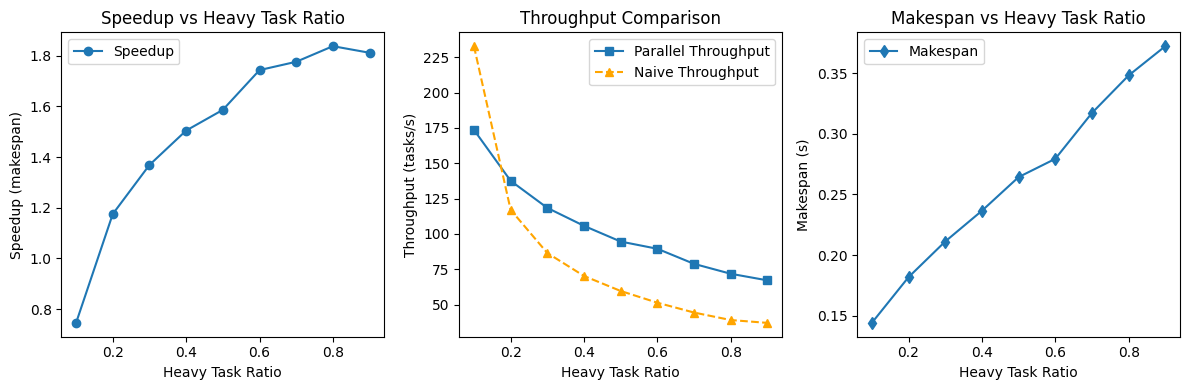

In [33]:
import os
import csv
import matplotlib.pyplot as plt
from collections import defaultdict

def run_multiple_experiments(k: int, num_tasks: int = 15):
    ratios = [round(i / 10, 1) for i in range(1, 10)]
    speedups = []
    parallel_throughputs = []
    naive_throughputs = []
    makespans = []
    config = defaultdict(dict)
    csv_filename = "experiment_results.csv"
    pdf_filename = "experiment_plots.pdf"
    profiling_file = "profiling_results.csv"



    for ratio in ratios:
        heavy_count = int(num_tasks * ratio)
        light_count = num_tasks - heavy_count
        print(f"Running experiment with {heavy_count} heavy and {light_count} light tasks.")

        # Remove profiling results if exists
        if os.path.exists(profiling_file):
            os.remove(profiling_file)
            print("The profiling file was removed.")

        evaluator = run_experiment(k=k, heavy_light_ratio=(heavy_count, light_count), num_tasks=num_tasks)
        sp = evaluator.speedup_makespan
        par_th = evaluator.throughput_makespan
        naive_thr = num_tasks / evaluator.naive_makespan if evaluator.naive_makespan > 0 else 0
        mk = evaluator.parallel_makespan

        speedups.append(sp)
        parallel_throughputs.append(par_th)
        naive_throughputs.append(naive_thr)
        makespans.append(mk)

        config[ratio] = {
            'speedup': sp,
            'parallel_throughput': par_th,
            'naive_throughput': naive_thr,
            'makespan': mk
        }

        print(f"Speedup for ratio {ratio}: {sp:.2f}")
        print(f"Parallel Throughput for ratio {ratio}: {par_th:.2f}")
        print(f"Naive Throughput for ratio {ratio}: {naive_thr:.2f}")
        print(f"Makespan for ratio {ratio}: {mk:.2f}\n")

    print("Final Results:")
    print("Speedups:", speedups)
    print("Parallel Throughputs:", parallel_throughputs)
    print("Naive Throughputs:", naive_throughputs)
    print("Makespans:", makespans)

    # Save results to CSV
    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Heavy Task Ratio", "Speedup", "Parallel Throughput", "Naive Throughput", "Makespan"])
        for i, ratio in enumerate(ratios):
            writer.writerow([ratio, speedups[i], parallel_throughputs[i], naive_throughputs[i], makespans[i]])
    print(f"Experiment results saved to {csv_filename}")

    # Find the best configuration based on maximum speedup
    max_ratio = max(config, key=lambda r: config[r]['speedup'])
    best_config = config[max_ratio]

    print(f"Best configuration: {best_config}")
    print(f"Max Speedup Ratio: {max_ratio}\n")

    # Plot results
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].plot(ratios, speedups, marker='o', linestyle='-', label='Speedup')
    axes[0].set_xlabel("Heavy Task Ratio")
    axes[0].set_ylabel("Speedup (makespan)")
    axes[0].set_title("Speedup vs Heavy Task Ratio")
    axes[0].legend()

    axes[1].plot(ratios, parallel_throughputs, marker='s', linestyle='-', label='Parallel Throughput')
    axes[1].plot(ratios, naive_throughputs, marker='^', linestyle='--', label='Naive Throughput', color='orange')
    axes[1].set_xlabel("Heavy Task Ratio")
    axes[1].set_ylabel("Throughput (tasks/s)")
    axes[1].set_title("Throughput Comparison")
    axes[1].legend()

    axes[2].plot(ratios, makespans, marker='d', linestyle='-', label='Makespan')
    axes[2].set_xlabel("Heavy Task Ratio")
    axes[2].set_ylabel("Makespan (s)")
    axes[2].set_title("Makespan vs Heavy Task Ratio")
    axes[2].legend()

    plt.tight_layout()
    plt.savefig(pdf_filename)
    print(f"Plots saved to {pdf_filename}")
    plt.show()

if __name__ == "__main__":
    run_multiple_experiments(k=2, num_tasks=25)